<a href="https://colab.research.google.com/github/okana2ki/multiV/blob/main/kmeans_SSDSE_C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 機械学習帳：[非階層的クラスタリング](https://colab.research.google.com/github/chokkan/mlnote/blob/main/unsupervised/01kmeans.ipynb) より

## 確認問題

[教育用標準データセット（SSDSE）](https://www.nstac.go.jp/SSDSE/)に収録されている都道府県庁所在市別・家計消費データ（SSDSE-C）に対してクラスタ分析を適用し、消費行動が類似している都道府県のクラスタを作りたい。

### (1) データセットの読み込み

このデータセットを読み込み、各都道府県庁所在地を特徴ベクトルで表現せよ。

In [ ]:
# prompt: https://www.nstac.go.jp/sys/files/SSDSE-C-2024.csv を読み込み、先頭5行を表示

import pandas as pd

url = "https://www.nstac.go.jp/sys/files/SSDSE-C-2024.csv"
df = pd.read_csv(url, encoding="shift-jis")

# 先頭5行を表示
df.head()


,SSDSE-C-2024,2021-2023年,City,LA03,LB00,LB01,LB011001,LB012001,LB012002,LB013001,...,LB121104,LB121105,LB121106,LB121107,LB121108,LB121109,LB121110,LB121201,LB121202,LB122001
0,地域コード,都道府県,市,世帯人員,食料（合計）,01 穀類,米,食パン,他のパン,生うどん・そば,...,すし（外食）,和食,中華食,洋食,焼肉,ハンバーガー,他の主食的外食,喫茶代,飲酒代,学校給食
1,R00000,全国,全国,2.91,991375,79156,20695,10374,22201,3617,...,14320,21156,4250,10162,6859,5711,44573,7621,10022,9402
2,R01100,北海道,札幌市,2.78,927878,77764,24470,9315,18880,3199,...,17474,21403,3255,13998,7193,4152,24593,5491,11936,13392
3,R02201,青森県,青森市,2.83,930707,75496,20421,8526,18440,3527,...,12312,14359,2287,7104,6445,4522,17807,3252,6424,7373
4,R03201,岩手県,盛岡市,3.03,980028,80403,22223,8565,21070,3365,...,13385,11332,2133,5571,7280,4571,30942,4379,9147,11492


* ダウンロードしてきたファイルを読み込んでもよいのですが、今回は、サイトから直接ファイルを読み込むことにしました。
* いきなり、特徴ベクトル表現をしてもよいのですが、まず、読み込むだけ、というように**小分けに指示**して、**内容を確認しながら**進むことにしました。複雑なプログラムを作るときは、段階を踏んで作っていく方がお勧めです。
* 今回のような依頼の仕方をすると、shift-jisであることは、AIが適切に判断してくれることが多いようです。
* ここで読み込んだ内容を確認しておくと、この後、特徴ベクトルを抽出したときに、うまくできているかの確認が容易です。




In [ ]:
# prompt: 各都道府県庁所在地（2行目以降）を特徴ベクトル（4列目以降）で表現し、先頭5行を表示

# 各都道府県庁所在地（2行目以降）を特徴ベクトル（4列目以降）で表現
df_features = df.iloc[2:, 4:]

# 先頭5行を表示
df_features.head()


,LB00,LB01,LB011001,LB012001,LB012002,LB013001,LB013002,LB013003,LB013004,LB013005,...,LB121104,LB121105,LB121106,LB121107,LB121108,LB121109,LB121110,LB121201,LB121202,LB122001
2,927878,77764,24470,9315,18880,3199,2225,1354,4216,6009,...,17474,21403,3255,13998,7193,4152,24593,5491,11936,13392
3,930707,75496,20421,8526,18440,3527,2310,1217,5710,7496,...,12312,14359,2287,7104,6445,4522,17807,3252,6424,7373
4,980028,80403,22223,8565,21070,3365,2524,1299,6530,6777,...,13385,11332,2133,5571,7280,4571,30942,4379,9147,11492
5,1003139,78668,19465,9804,22211,3252,1889,1367,5082,7077,...,13369,20059,2800,10008,5289,5664,26936,7124,11362,10454
6,952812,71734,18662,7918,17541,3616,4348,1226,5697,6007,...,15195,15785,1964,5841,7753,3748,24990,3845,9315,12760


* **2行目以降という指示**なしに自動で判断させることは難しいようでした。1行目の全国を除こうと思ったので、こうしました。なお、0行目から始まるので、その数え方で指示しましたが、1行目から始まる数え方で指示してもAIが判断してくれることもあると思います。
* **4列目以降**というのを指示なしで自動判断するのも難しいようです。食料（合計）の列以降、というつもりです。「消費行動の類似性でクラスタリングせよ」というお題なので、「世帯人員」列を除くのは妥当だと思います。「食料（合計）」は、それ以降の列の合計なので、冗長な特徴になっていると思われるので、これも除くという考えもあると思います。また、「穀類」のような小計の列もあり、これも除いた方がよいかもしれませんが、どの列を除くかの指示が面倒なので、小計も合計も含まれたままにしました。（実は、これが後で問題になります。）
* 丁寧に分析するなら、「世帯人員」で、各品目の支出額を正規化するという分析が望ましいかもしれませんが、今回はそれはしていません。各品目の支出額は一世帯当たりで集計されているので、それで正規化した方が消費の特徴を表しているとも言えるし、世帯人数の多少も含めて支出額の特徴を捉えるという考えもあると思います。
* 各品目の支出額は一世帯当たりで集計されている、というようなことは、[SSDSEのHP](https://www.nstac.go.jp/use/literacy/ssdse/)の[**データごとの解説資料**](https://www.nstac.go.jp/sys/files/kaisetsu-C-2024.pdf)に書いてあります。**適切な分析のためには、分析前に解説に目を通しておくことが必要**ですね。
* ここで**抽出した結果を表示して、意図通りにできていることを確認**して、次に進みます。
* 元のデータの0行目の品目名や、2列目の都市名がdf_featuresには含まれておらず、分かりにくくなっているのですが、必要になれば、後で何とか回復できるだろうと思うので、ここはそのままにして進みます。

### (2) WCSSのプロット

K-meansクラスタリングを異なるクラスタ数$K$で実行し、横軸にクラスタ数、縦軸にK-meansの目的関数の値、すなわちクラスタ内平方和（WCSS: within-cluster sum-of-squares）をプロットしたグラフを描画せよ。

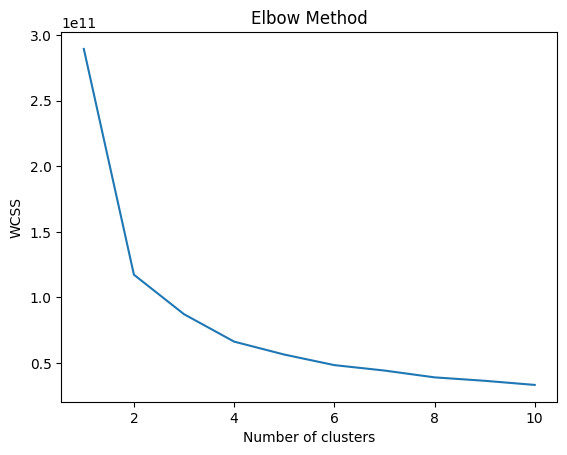

In [ ]:
# prompt: K-meansクラスタリングを異なるクラスタ数 K で実行し、横軸にクラスタ数、縦軸にK-meansの目的関数の値、すなわちクラスタ内平方和（WCSS: within-cluster sum-of-squares）をプロットしたグラフを描画せよ。

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# クラスタ数の上限
max_clusters = 10

# クラスタ数ごとのWCSSを格納するリスト
wcss = []

# 異なるクラスタ数でK-meansクラスタリングを実行
for i in range(1, max_clusters + 1):
  kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)  # n_init: 初期化回数（何回試すか）を明示的に指定することで警告メッセージを回避
  kmeans.fit(df_features)

  # クラスタ内平方和（WCSS）をリストに追加
  wcss.append(kmeans.inertia_)

# クラスタ数とWCSSをプロット
plt.plot(range(1, max_clusters + 1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


↑このグラフが何のことか分からない人は、[この資料](https://colab.research.google.com/github/chokkan/mlnote/blob/main/unsupervised/01kmeans.ipynb)の目次から「クラスタ数の選び方」を参照。

* 以上のように、問題文をそのままプロンプトに入力すると、うまくプログラミングできた！と一瞬喜んでしまうかもしれませんが、ここで、落ち着いて、データを見直してみましょう。
* すると、**品目によって、支出額の多少に開きがある**のはもちろん、小計や合計もあるので、**特に一番大きい「食料（合計）」という特徴量が大きく効いて**、**ほぼ「食料（合計）」の多少だけでクラスタリングが決まってしまっているのではないか**と想像できます。
* これでは、題意であった「消費行動の類似性」によりクラスタリングしたことにはなっていませんよね。ほぼ合計額だけを考慮してクラスタリングしたことになってしまっていると思います。
* このような結果になってしまっていることをちゃんとデータで確認するには、このまま次の(3)に進んで、各クラスタに属する都市名を洗い出すか、または、クラスタごとの「食料（合計）」の箱ひげ図を描くと、確認できると思います。ぜひ、この確認にチャレンジしてみて下さい。**←今日の宿題その１**

*  「食料（合計）」列の各要素は**文字列**なので、**数値に変換**して箱ひげ図を書く必要があることに注意
*  df_featuresは、**「食料（合計）」列**という情報は持っていないので**LB00列**と指定する必要があることにも注意

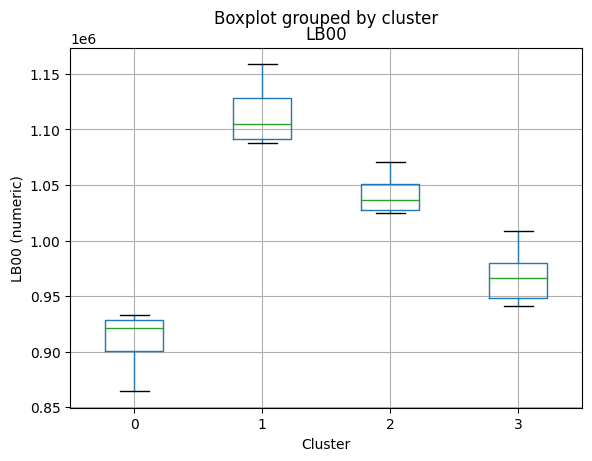

In [ ]:
# prompt: クラスタ数4でK-meansクラスタリングを実行し、クラスタごとの”LB00”（数値に変換したもの）の箱ひげ図を書いて下さい。

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# クラスタ数
n_clusters = 4

# KMeansクラスタリングを実行
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
kmeans.fit(df_features)

# クラスタ番号とLB00列の値（数値に変換）を格納するリスト
cluster_and_LB00 = []

# 各データのクラスタ番号とLB00列の値（数値に変換）を取得
for i in range(len(df_features)):
  cluster_and_LB00.append([kmeans.labels_[i], int(df['LB00'].iloc[i+2])])

# クラスタごとの”LB00”（数値に変換したもの）の箱ひげ図を描く
df_box = pd.DataFrame(cluster_and_LB00, columns=['cluster', 'LB00'])
df_box.boxplot(column='LB00', by='cluster')
plt.xlabel('Cluster')
plt.ylabel('LB00 (numeric)')
plt.show()


上の箱ひげ図を見ると、**予想通り、食料（合計）の値によってクラスタリングされた（他の特徴量はほぼ無関係であった）**ことが確認できる。


* さて、この「大きな値の特徴量にクラスタリング結果が左右されてしまう」という問題は、どう対処したらよいでしょうか？
* ひとつの方法は、**小計や合計をデータから除く**ことです。この方法が「消費行動の類似性」によりクラスタリングするという目的からは、正しい対処方法かもしれません。ただ、ちょっと、除くための指示が面倒なので、ここでは別の対処方法をとろうと思います。
* なお、合計や小計をデータから除くのは、個別に指示しなくても、一括指示することはおそらくできると思います。どうしてかというと、一番上の行（各列の識別記号）を見ると、合計や小計は、LB00やLB01のような短かいコードが割り振られているからです。ただ、合計や小計も特徴量だと捉えてクラスタリングするという考えもありかなとも思います。
* もう一つの方法は、**データを前処理してから、クラスタリング**を行う方法です。この前処理は、個別の品目の支出額だけを残したデータとした場合も、それらの支出額の間に大き目の開きがある場合は、有効に働きます。
* どのような前処理をするとよいか、ぜひ考えて、それを実行してみて下さい。その後、クラスタリングを実行して、結果を前処理しなかった場合と比べて下さい。**←今日の宿題その２**。AIに質問しても、おそらく正しい前処理を教えてくれると思います。

* 前処理のヒントを書いておくと、「標準化」です。「標準化」と「正規化」については、[ここ](https://qiita.com/oki_kosuke/items/02ec7bee92c85cf10ac2)を参照して内容やそれをする理由を理解してから、プログラムを書いて実行して下さい。キーワードだけ聞いて、AIにプログラムを頼んでおしまい、では力がつきません。AIに理由とかも尋ねながらプログラミングするという勉強スタイルであれば、それでいいのですが。

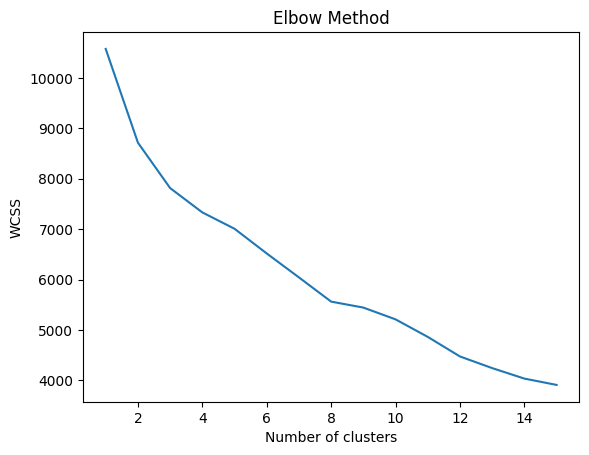

In [ ]:
# prompt: まず各特徴量を標準化して下さい。それに続いて、K-meansクラスタリングを異なるクラスタ数 K で実行し、横軸にクラスタ数、縦軸にK-meansの目的関数の値、すなわちクラスタ内平方和（WCSS: within-cluster sum-of-squares）をプロットしたグラフを描画せよ。

from sklearn.preprocessing import StandardScaler

# データを標準化（平均=0, 標準偏差=1に）
scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(df_features)

# クラスタ数の上限
max_clusters = 15

# クラスタ数ごとのWCSSを格納するリスト
wcss = []

# 異なるクラスタ数でK-meansクラスタリングを実行
for i in range(1, max_clusters + 1):
  kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)  # n_init: 初期化回数（何回試すか）を明示的に指定することで警告メッセージを回避
  kmeans.fit(df_features_scaled)

  # クラスタ内平方和（WCSS）をリストに追加
  wcss.append(kmeans.inertia_)

# クラスタ数とWCSSをプロット
plt.plot(range(1, max_clusters + 1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


### (3) K-meansクラスタリング

(2)の結果に基づき、クラスタ数$K$を適当に選び、K-meansクラスタリングを実行せよ。$1$から$K$までの各クラスタに対して、それぞれ所属する都道府県庁所在地を明らかにせよ。**←今日の宿題その３**

*  上のグラフから分かるように、**ひじの位置がはっきりしないので、これに基づいてKを選ぶのは難しい**のですが、以下では、K=3, 4, 8の３つの場合を調べています。
*  **都道府県庁所在地を書かせるところは一工夫必要**です。以下では、「**dfのCity列に記されている**」と教えています。この情報をAIが自分で見つけるのはおそらく難しいと思うので、このように人が助けてあげることが有効です。


In [ ]:
# prompt: K=3, 4, 8のそれぞれに対して、K-meansクラスタリングを実行せよ。1 からKまでの各クラスタに対して、それぞれ所属する都道府県庁所在地を明らかにせよ。都道府県庁所在地は、dfのCity列に記されている。

# K=3の場合
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans.fit(df_features_scaled)

cluster_and_city = []
for i in range(len(df_features_scaled)):
  cluster_and_city.append([kmeans.labels_[i], df['City'].iloc[i+2]])

df_cluster_city = pd.DataFrame(cluster_and_city, columns=['cluster', 'City'])

print('K=3')
for i in range(3):
  print(f'クラスタ{i+1}：', df_cluster_city[df_cluster_city['cluster'] == i]['City'].tolist())

# K=4の場合
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10)
kmeans.fit(df_features_scaled)

cluster_and_city = []
for i in range(len(df_features_scaled)):
  cluster_and_city.append([kmeans.labels_[i], df['City'].iloc[i+2]])

df_cluster_city = pd.DataFrame(cluster_and_city, columns=['cluster', 'City'])

print('K=4')
for i in range(4):
  print(f'クラスタ{i+1}：', df_cluster_city[df_cluster_city['cluster'] == i]['City'].tolist())

# K=8の場合
kmeans = KMeans(n_clusters=8, random_state=0, n_init=10)
kmeans.fit(df_features_scaled)

cluster_and_city = []
for i in range(len(df_features_scaled)):
  cluster_and_city.append([kmeans.labels_[i], df['City'].iloc[i+2]])

df_cluster_city = pd.DataFrame(cluster_and_city, columns=['cluster', 'City'])

print('K=8')
for i in range(8):
  print(f'クラスタ{i+1}：', df_cluster_city[df_cluster_city['cluster'] == i]['City'].tolist())


K=3
クラスタ1： ['福井市', '津市', '和歌山市', '鳥取市', '松江市', '岡山市', '広島市', '山口市', '徳島市', '高松市', '松山市', '高知市', '福岡市', '佐賀市', '長崎市', '熊本市', '大分市', '宮崎市', '鹿児島市', '那覇市']
クラスタ2： ['さいたま市', '千葉市', '東京都区部', '横浜市', '富山市', '金沢市', '岐阜市', '静岡市', '名古屋市', '大津市', '京都市', '大阪市', '神戸市', '奈良市']
クラスタ3： ['札幌市', '青森市', '盛岡市', '仙台市', '秋田市', '山形市', '福島市', '水戸市', '宇都宮市', '前橋市', '新潟市', '甲府市', '長野市']
K=4
クラスタ1： ['福岡市', '佐賀市', '長崎市', '熊本市', '大分市', '宮崎市', '鹿児島市', '那覇市']
クラスタ2： ['さいたま市', '千葉市', '東京都区部', '横浜市', '富山市', '金沢市', '岐阜市', '静岡市', '名古屋市', '大津市', '京都市', '大阪市', '神戸市', '奈良市']
クラスタ3： ['札幌市', '青森市', '盛岡市', '仙台市', '秋田市', '山形市', '福島市', '水戸市', '宇都宮市', '前橋市', '新潟市', '甲府市', '長野市']
クラスタ4： ['福井市', '津市', '和歌山市', '鳥取市', '松江市', '岡山市', '広島市', '山口市', '徳島市', '高松市', '松山市', '高知市']
K=8
クラスタ1： ['福井市', '鳥取市', '松江市', '山口市', '福岡市', '佐賀市', '長崎市', '熊本市', '大分市', '宮崎市', '鹿児島市']
クラスタ2： ['富山市', '金沢市', '岐阜市', '名古屋市', '大津市', '京都市', '大阪市', '神戸市', '奈良市']
クラスタ3： ['さいたま市', '千葉市', '東京都区部', '横浜市', '静岡市']
クラスタ4： ['札幌市', '青森市', '秋田市']
クラスタ5： ['盛岡市', '仙台市', '山形市

*  以上のように、各クラスタに所属している都市名を見ると、**近隣地域の都市がクラスタを形成していることが多く**、これはそれらの都市間で消費支出の傾向が似ていることを反映しているのだと思います。


# 主成分分析

## 演習問題１

1. 標準化後のデータに対して、第20主成分まで主成分分析を行いなさい。

2. 主成分の数 k を横軸、累積寄与率を縦軸としてグラフを描画しなさい。

3. 第1主成分得点を横軸、第2主成分得点を縦軸として、各都道府県庁所在地の消費支出金額を2次元平面上にプロットしなさい。プロットした各点に都市名を付記すること。

ヒント：まず、グラフ内で日本語を表示できるようにしておきます。

In [ ]:
!pip install japanize-matplotlib

In [ ]:
import japanize_matplotlib